In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate

def generate_populations_dataset():
    SH = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
    CL = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])

    X = np.zeros((len(SH),2))
    X[:,0] = SH
    X[:,1] = CL

    dt = 2
    t = np.arange(1845,1903+dt,dt) 
    return X,t,dt


def interpolation(t ,X, t_new,type = 'interp1'):
    
    if type == 'interp1':
        f_0 = interpolate.interp1d(t, X[:,0])
        f_1 = interpolate.interp1d(t, X[:,1])
        X_new = np.zeros((len(t_new),2))
        X_new[:,0] = f_0(t_new)
        X_new[:,1] = f_1(t_new)
    else:
        f_0 = interpolate.splrep(t, X[:,0])
        f_1 = interpolate.splrep(t, X[:,1])
        X_new = np.zeros((len(t_new),2))
        X_new[:,0] = interpolate.splev(t_new, f_0)
        X_new[:,1] = interpolate.splev(t_new, f_1)

    return X_new


def sim(variables, t, params):

    x = variables[0]
    y = variables[1]

    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y

    return([dxdt, dydt])

def loss_function(params, years,SH_pop, CL_pop):

    y0 = [SH_pop[0], CL_pop[0]]
    t0 = 0
    t = np.linspace(years[0], years[-1], num=len(years))
    output = odeint(sim, y0, t, rtol = r_tol, atol = a_tol , hmax = hmax , hmin = hmin ,args=(params,))

    loss = 0

    for i in range(len(years)):
        data_SH = SH_pop[i]
        model_SH = output[i,0]
        data_CL = CL_pop[i]
        model_CL = output[i,1]
        res = (data_SH - model_SH)**2 + (data_CL - model_CL)**2

        loss += res

    return(loss)



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


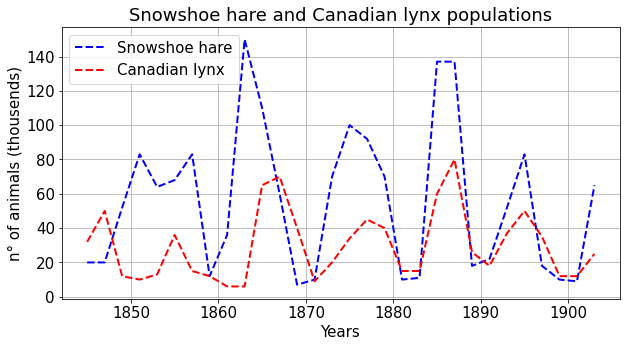

5800
Optimization terminated successfully.
         Current function value: 7453223.048202
         Iterations: 391
         Function evaluations: 746
alpha:  1.1102890304964905
beta:  0.042296262728844354
delta:  0.006303090082685032
gamma:  0.30463300150365447


In [2]:
X,t,dt = generate_populations_dataset()


font = {'family' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Snowshoe hare and Canadian lynx populations')
ax.plot(t,X[:,0],'--b',linewidth = 2)
ax.plot(t,X[:,1],'--r',linewidth = 2)
ax.set_ylabel('n° of animals (thousends)',fontsize=15)
ax.set_xlabel('Years',fontsize=15)
ax.legend(['Snowshoe hare','Canadian lynx'])
ax.grid()

plt.show()

# shift the time axis from 0 to 58
t = np.linspace(0,60-2,len(X))

# Interpolation flag
interpolation_active = True

if interpolation_active == True:
    dt_new = 0.01
    t_new = np.arange(t[0],t[-1],dt_new)
    X_new = interpolation(t ,X, t_new,'interp1')
    print(len(t_new))
    t = t_new
    X = X_new
    dt = dt_new


years = t.tolist()
SH_pop = X[:,0].tolist()
CL_pop = X[:,1].tolist()

# ode int settings
r_tol = 1e-4
a_tol = 1e-4
hmax = 1e2
hmin = 1e-2

scale_factor = 3/60

# initial guess
params0_alpha = 15*scale_factor
params0_beta = 0.5*scale_factor
params0_gamma = 0.15*scale_factor
params0_delta = 8*scale_factor

params0 = np.array([params0_alpha, params0_beta, params0_gamma, params0_delta])

minimum = scipy.optimize.fmin(loss_function, params0, args=(years,SH_pop, CL_pop))

alpha_fit = minimum[0]
beta_fit = minimum[1]
delta_fit = minimum[2]
gamma_fit = minimum[3]

print('alpha:  '+str(alpha_fit))  
print('beta:  '+str(beta_fit))  
print('delta:  '+str(delta_fit))  
print('gamma:  '+str(gamma_fit))  

params = [alpha_fit, beta_fit, delta_fit, gamma_fit]

y0 = [SH_pop[0], CL_pop[0]]
t_sim = np.linspace(years[0], years[-1], num=int(1e5))
t0 = 0

output = odeint(sim, y0, t_sim, rtol = r_tol, atol = a_tol ,args=(params,))


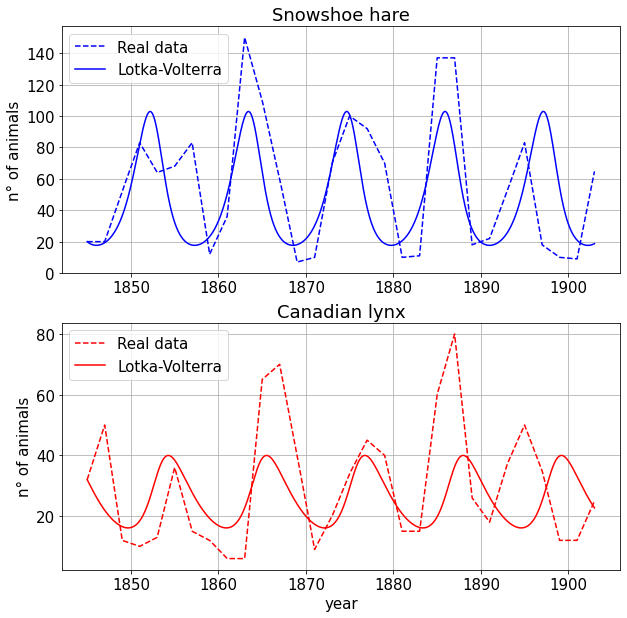

In [4]:
font = {'family' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].set_title('Snowshoe hare')
ax[0].plot(t+1845,X[:,0],'--b')
ax[0].plot(t_sim+1845,output[:,0], color="b")
ax[0].set_ylabel('n° of animals',fontsize=15)
ax[0].legend(['Real data','Lotka-Volterra'])
ax[0].grid()

ax[1].set_title('Canadian lynx')
ax[1].plot(t+1845,X[:,1],'--r')
ax[1].plot(t_sim+1845,output[:,1], color="r") 
ax[1].set_xlabel('year',fontsize=15)
ax[1].set_ylabel('n° of animals',fontsize=15)
ax[1].legend(['Real data','Lotka-Volterra'])
ax[1].grid()

plt.show()